This notebook holds the code to reproduce the Sobol' robustness results for the contaminant transport exemplar

In [1]:
import os, sys
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
from MFU_representations import FRADESobols, generalizedADEDataConsistentSobols

# For parallel processing and file I/O
from joblib import Parallel, delayed
import pickle

from matplotlib import rcParams
rcParams['text.usetex'] = True
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times']
rcParams['text.latex.preamble'] = r'\usepackage{amssymb}'

In [2]:
results_dir = 'results/sobol_robustness/'
if not os.path.exists(results_dir): os.makedirs(results_dir)

# Anomalous diffusion example

Visualizing the difference between heterogeneous and homogeneous porous media

In [3]:
import h5py
h5f = h5py.File('DNS_data/homogeneous_vs_heterogeneous.h5', 'r')

x = np.array(h5f['x'])
t = h5f['t'][...]
uhom = np.array(h5f['homogeneous/streamwise_velocity'])
chom = np.array(h5f['homogeneous/gaussian'])
uhet = np.array(h5f['heterogeneous/streamwise_velocity'])
chet = np.array(h5f['heterogeneous/gaussian'])

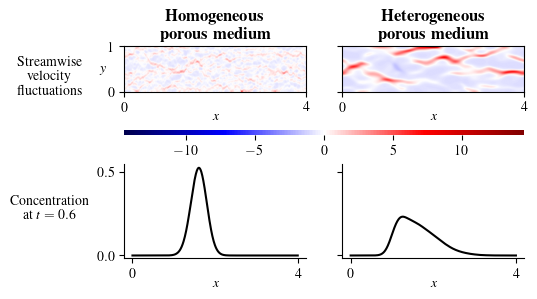

In [ ]:
fig = plt.figure(figsize=(5,2.5))
axs = fig.subplots(2,2, sharey='row',gridspec_kw={'height_ratios': [1, 2]})

uhom_fluc = (uhom-1).T
uhet_fluc = (uhet-1).T
vlim = max(np.abs(uhom_fluc).max(),np.abs(uhet_fluc).max())
cbar = axs[0][0].imshow(uhom_fluc, vmin=-vlim, vmax=vlim, cmap='seismic', extent=[0,4,0,1])
axs[0][1].imshow(uhet_fluc, vmin=-vlim, vmax=vlim, cmap='seismic', extent=[0,4,0,1])
for ax in axs[0]:
    ax.set_xticks([0,4])
    ax.set_yticks([0,1])
    ax.set_xlabel(r'$x$', labelpad=-2.5)
axs[0][0].set_ylabel(r'$y$', rotation=0, va='center')


# Adjust spacing to make room for colorbar
fig.subplots_adjust(hspace=1, left=0.1, right=0.9, top=0.95, bottom=0.1)

# Create colorbar axis manually between the rows and spanning roughly the width of both imshow plots
cbar_ax = fig.add_axes([0.1, 0.59, 0.8, 0.02])  # [left, bottom, width, height] in figure coords
fig.colorbar(cbar, cax=cbar_ax, orientation='horizontal')
for spine in cbar_ax.spines.values():
    spine.set_visible(False)

for ax, c in zip(axs[1],[chom,chet]):
    ax.plot(x,c, 'k')
    ax.spines[['top','right']].set_visible(False)
    ax.set_xticks([0,4])
    ax.set_yticks([0,0.5])
    ax.set_ylim([-.015,0.55])
    ax.set_xlabel(r'$x$', labelpad=-2.5)

fig.text(-.05, 0.825, "Streamwise\nvelocity\nfluctuations", ha='center', va='center', rotation=0);
fig.text(-.05, 0.3, 'Concentration\nat '+rf'$t={t}$', rotation=0, ha='center', va='center');
axs[0][0].set_title(r"\textbf{Homogeneous}"+'\n'+r"\textbf{porous medium}");
axs[0][1].set_title(r"\textbf{Heterogeneous}"+'\n'+r"\textbf{porous medium}");
fig.savefig(f'results/sobol_robustness/anomalous_diffusion_example.pdf', bbox_inches='tight')

# Forward propagation

First we want to show samples of the fractional derivative as a function of $x$.

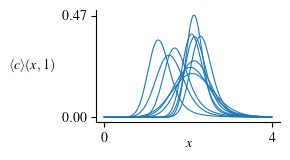

In [5]:
FRADE = FRADESobols()

np.random.seed(20250705)
X = FRADE.get_input_samples(10)
Y = FRADE.f_fieldX(X, t=1)

fig = plt.figure(figsize=(3,1.7))
ax = fig.add_subplot(111)
for yi in Y:
    ax.plot(FRADE.x, yi, 'C0', lw=0.8)

ax.set_xticks([0,4])
ax.set_xlabel(r'$x$', labelpad=-5)
ax.set_ylabel(r'$\langle c\rangle(x,1)$', rotation=0, ha='right', va='center')
ax.set_yticks([0, np.round(Y.max(),2)])
ax.spines[['top','right']].set_visible(False)

fig.tight_layout()
fig.savefig(f'{results_dir}/FRADE_samples.pdf')

Now a histogram of the QoI.

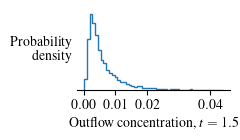

In [6]:
np.random.seed(20250705)
X = FRADE.get_input_samples(5000)
Y = FRADE.fX(X)

fig = plt.figure(figsize=(2.5,1.5))
ax = fig.add_subplot(111)
ax.hist(Y, density=True, histtype='step', bins=50)
ax.set_xlabel(r'Outflow concentration, $t=1.5$');
ax.set_ylabel('Probability\ndensity', rotation=0, ha='right', va='center');
ax.set_yticks([])
ax.spines[['top','right','left']].set_visible(False)

qmean = np.round(Y.mean(),2)
q95 = np.round(np.quantile(Y, 0.95),2)
qmax = np.round(Y.max(),2)
ax.set_xticks([0,qmean,q95, qmax]);
fig.tight_layout()
fig.savefig(f'{results_dir}/FRADE_qoi_samples.pdf')

# Sobol robustness

Here we want to generate two MFU distributions with very different parameterizations but with similar influence on output statistics. We then show that the recovered Sobol' indices are similar.

We do this by using data-consistent inversion to develop a distribution on generalized ADE eigenvalues that is close to the eigenvalue distribution imposed by the fractional derivative MFU representation. 

#### Visualizing the data-consistent update

In [ ]:
N = 50000
seed = 20250705

np.random.seed(seed) 
gADE_model = generalizedADEDataConsistentSobols(std_scale=1.25, make_plots=False)

np.random.seed(seed)
X = gADE_model.get_eigenvalue_samples_with_nominals(N)
q = gADE_model.fX(X)
q_original = q.copy()

# Going ahead and screening out samples with negative concentration.
filter_inds = np.where( (np.max(gADE_model.FRADE_samples)>=q) & (q >0))
X = X[filter_inds]
q = q[filter_inds]

pred_kde = ss.gaussian_kde(q)
    
r = gADE_model.obs_kde.evaluate(q) / pred_kde.evaluate(q)
print(f"Mean rejection ratio (should be >= 1): {np.nanmean(r):.2f}")

t = np.random.uniform(size=r.size)
accept_reject = np.less_equal( t, r/np.nanmax(r) )
N_accepted = np.sum(accept_reject)

Xup =  X[accept_reject]
qup = gADE_model.fX(Xup)
updated_kde = ss.gaussian_kde(qup)

Mean rejection ratio (should be >= 1): 1.00


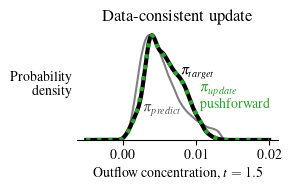

In [ ]:
fig = plt.figure(figsize=(3,2))
ax = fig.add_subplot(111)
x = np.linspace(-.005, 0.02, 1000)
ax.plot(x, pred_kde(x), 'grey', label='Prediction distribution')
ax.annotate(r'$\pi_{predict}$', (0.00785, 50), ha='right', va='center', color='#525252')

ax.plot(x, gADE_model.obs_kde(x), 'k', lw=3,  label='Observation distribution')
ax.annotate(r'$\pi_{target}$', (0.008, 110), ha='left', va='center')

ax.plot(x, updated_kde(x), 'C2', linestyle='dotted', lw=3, label='Updated distribution')
ax.annotate(r'$\pi_{update}$'+'\npushforward', (0.0105, 70), ha='left', va='center', color='C2')
ax.set_xlabel(r'Outflow concentration, $t=1.5$');
ax.set_ylabel('Probability\ndensity', rotation=0, ha='right', va='center');
ax.set_yticks([])
ax.spines[['top','right','left']].set_visible(False)
ax.set_ylim([0, ax.get_ylim()[-1]])
ax.set_title("Data-consistent update");

fig.tight_layout()
fig.savefig(f'{results_dir}/data_consistent_update.pdf');

#### Replicate sample generation

Warning--the following code takes about 45 minutes to complete.

In [ ]:
replicate_dir = f'{results_dir}/replicate_samples/'
if not os.path.exists(replicate_dir): os.makedirs(replicate_dir)

def replicate_sobol_sample(seed_offset=0):
    N = 50000
    seed = 20250705 + seed_offset

    frade_model = FRADESobols()
    np.random.seed(seed)
    # Rescaling so FRADE QoI variance is 1.
    scaling_factor = np.std(frade_model.fX(frade_model.get_input_samples(N)))
    frade_model.qoi_rescale_factor = scaling_factor

    np.random.seed(seed)
    frade_model.compute_sobol_indices(N)
    pickle.dump(frade_model.results, open(f'{replicate_dir}/frade_sobols_{seed_offset}.pkl', 'wb') )

    np.random.seed(20250705) # This is used for initial data-consistent update
    # Using the same scaling factor for the generalizedADE. 
    # Feeding it to ctor to ensure the FRADE
    # samples for the data-consistent update are also rescaled.
    gADE_model = generalizedADEDataConsistentSobols(std_scale=1.25, qoi_rescale_factor=scaling_factor,
  make_plots=False)
    np.random.seed(seed) # I think this should get us the same model parameter samples.
    gADE_model.compute_sobol_indices(N)
    pickle.dump(gADE_model.results, open(f'{replicate_dir}/gADE_sobols_{seed_offset}.pkl', 'wb') )

    print(f"Process {seed_offset} complete.")

Parallel(n_jobs=10)(delayed(replicate_sobol_sample)(i) for i in range(50))

#### Replicate sample processing

Now let's see what the replicates tell us.

In [3]:
n_replicates = 50
frade_main_effects = np.zeros((n_replicates, 4))
frade_total_effects = np.zeros((n_replicates,4))
frade_variances = np.zeros(n_replicates)
gADE_main_effects = np.zeros((n_replicates, 4))
gADE_total_effects = np.zeros((n_replicates,4))
gADE_variances = np.zeros(n_replicates)

for i in range(n_replicates):
    frade_results = pickle.load(open(f'{results_dir}/replicate_samples/frade_sobols_{i}.pkl', 'rb'))
    frade_main_effects[i] = frade_results['Main Effects']
    frade_total_effects[i] = frade_results['Total Effects']
    frade_variances[i] = frade_results['Variance']
    gADE_results = pickle.load(open(f'{results_dir}/replicate_samples/gADE_sobols_{i}.pkl', 'rb'))
    gADE_main_effects[i] = gADE_results['Main Effects']
    gADE_total_effects[i] = gADE_results['Total Effects']
    gADE_variances[i] = gADE_results['Variance']

In [17]:
gADE_variances.mean(), gADE_variances.std(ddof=1), (gADE_variances/frade_variances).mean()

(np.float64(1.0236405651052978),
 np.float64(0.014095601928254108),
 np.float64(1.024669169795109))

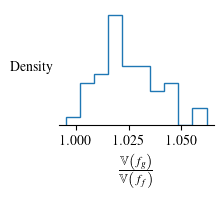

In [4]:
fig = plt.figure(figsize=(2,1.5))
ax = fig.add_subplot(111)
ax.hist(gADE_variances/frade_variances, histtype='step', density=True)
ax.set_yticks([])
ax.set_ylabel('Density', rotation=0, ha='right', va='center')
ax.spines[['top','left','right']].set_visible(False)
ax.set_xlabel(r'$\frac{\mathbb{V}\left(f_g\right)}{\mathbb{V}\left(f_f\right)}$', fontsize=12);

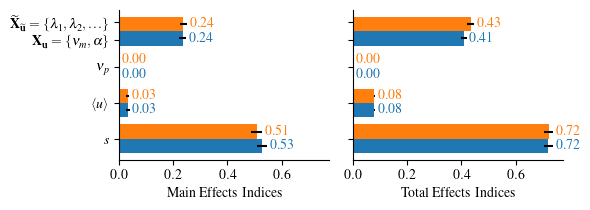

In [16]:
fig = plt.figure(figsize=(6,2.2))
axs = fig.subplots(1,2, sharey=True, sharex=True)

inds = np.arange(4)
ax = axs[0]
ax.set_xlabel('Main Effects Indices')
width=0.4
dv = width/2

ax.barh(inds-dv, frade_main_effects.mean(axis=0), xerr=2*frade_main_effects.std(axis=0, ddof=1), height=width)
ax.barh(inds+dv, gADE_main_effects.mean(axis=0), xerr=2*gADE_main_effects.std(axis=0, ddof=1), height=width)
ax.set_yticks([0,1,2,3-dv*1.3, 3+dv*1.3])
ax.set_yticklabels([r'$s$', r'$\langle u \rangle$', r'$\nu_p$', r'$\mathbf{X_u}=\left\{\nu_m, \alpha\right\}$', r'$\mathbf{\widetilde{X}}_{\mathbf{\widetilde{u}}}=\left\{\lambda_1, \lambda_2, \ldots\right\}$']);

for i, rf, rg in zip(inds, frade_main_effects.T, gADE_main_effects.T):
    fmean = rf.mean(axis=0)
    fub = fmean + 2*rf.std(axis=0, ddof=1) + 0.01
    ax.annotate(f'{fmean:.2f}', (fub,i-dv), color='C0', va='center', ha='left')
    
    gmean = rg.mean(axis=0)
    gub = gmean + 2*rg.std(axis=0, ddof=1) + 0.01
    ax.annotate(f'{gmean:.2f}', (gub,i+dv), color='C1', va='center', ha='left')

ax = axs[1]
ax.set_xlabel('Total Effects Indices')
ax.barh(inds-dv, frade_total_effects.mean(axis=0), xerr=2*frade_total_effects.std(axis=0, ddof=1), height=width)
ax.barh(inds+dv, gADE_total_effects.mean(axis=0), xerr=2*gADE_total_effects.std(axis=0, ddof=1), height=width)

for i, rf, rg in zip(inds, frade_total_effects.T, gADE_total_effects.T):
    fmean = rf.mean(axis=0)
    fub = fmean + 2*rf.std(axis=0, ddof=1) + 0.01
    ax.annotate(f'{fmean:.2f}', (fub,i-dv), color='C0', va='center', ha='left')
    
    gmean = rg.mean(axis=0)
    gub = gmean + 2*rg.std(axis=0, ddof=1) + 0.01
    ax.annotate(f'{gmean:.2f}', (gub,i+dv), color='C1', va='center', ha='left')


for ax in axs:
    ax.set_xlim([0,ax.get_xlim()[-1]])
    ax.spines[['top','right']].set_visible(False)

fig.tight_layout()
fig.savefig(f'{results_dir}/sobols_compared.pdf')

In [18]:
S_diff = np.abs(frade_main_effects[:,-1]-gADE_main_effects[:,-1])
T_diff = np.abs(frade_total_effects[:,-1]-gADE_total_effects[:,-1])

S_diff.mean(), S_diff.std(ddof=1), T_diff.mean(), T_diff.std(ddof=1)

(np.float64(0.008259041026723275),
 np.float64(0.0056158673315356705),
 np.float64(0.024991162987276026),
 np.float64(0.00799435394950134))

### Testing the derived bounds

Now we want to compute the epsilons associated with the derived bounds.

Warning--the following code takes 1-2 days to complete if you are not loading the computed integral values from file.

In [8]:
replicate_dir = f'{results_dir}/replicate_samples/bound_verification'
if not os.path.exists(f'{replicate_dir}/I1_49.txt'):
    if not os.path.exists(replicate_dir): os.makedirs(replicate_dir)

    sys.path.append('proof_verification')
    from QuadADE import *

    def replicate_bounds_sample(seed_offset=0):
        seed = 20250705 + seed_offset

        m = QuadADE(seed)
        I1 = m.outer_loop_integration()
        print(I1)
        with open(f'{replicate_dir}/I1_{seed_offset}.txt', 'w') as f:
            f.write(f'{I1}')
        return I1

    Parallel(n_jobs=16)(delayed(replicate_bounds_sample)(i) for i in range(50))

Postprocessing the replicate samples

In [9]:
postproc_dir='results/sobol_robustness/replicate_samples/bound_verification'
I_files = os.listdir(f'{postproc_dir}/')
Ivals = np.zeros(len(I_files))
for i,ifile in enumerate(I_files):
    Ivals[i] = np.loadtxt(f'{postproc_dir}/{ifile}')

Ivals.mean(), Ivals.std(ddof=1)

(np.float64(0.11708284238702672), np.float64(0.01575680804579746))

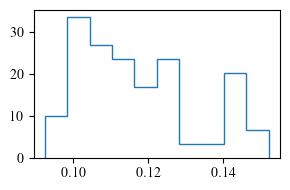

In [10]:
fig = plt.figure(figsize=(3,2))
ax = fig.add_subplot(111)
ax.hist(Ivals, density=True,histtype='step');
fig.tight_layout()